In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder

from scipy import stats
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import accuracy_score,  precision_score, f1_score, recall_score,classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")

# Pré-processamento dos dados






Lendo a base de dados e dispensando as colunas desnecessárias.

In [2]:
data = pd.read_csv('student_data.csv',sep=',', usecols = lambda column:column not in ['cod_curso','codigo_da_matricula','codigo_do_ciclo_matricula'])
data.head()

,nome_do_curso,carga_horaria_do_curso,eixo_tecnologico,fator_de_esforco_de_curso,tipo_de_curso,turno,codigo_sistec,categoria_de_situacao,data_de_inicio_do_ciclo,data_de_fim_previsto_do_ciclo,vagas_ofertadas,mes_de_ocorrencia_da_situacao,renda,sexo,faixa_etaria,idade,cor,unidade_de_ensino
0,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0,5<RFP<=1,0",F,20-24,24,parda,Campus João Pessoa
1,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0,5<RFP<=1,0",M,20-24,23,branca,Campus João Pessoa
2,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"RFP>3,5",M,20-24,21,parda,Campus João Pessoa
3,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0<RFP<=0,5",M,15-19,19,branca,Campus João Pessoa
4,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,2809,E,26/08/2019,26/08/2024,41.0,01/01/2021,"0<RFP<=0,5",M,15-19,19,branca,Campus João Pessoa


Convertendo os atributos que representam datas

In [3]:
data['data_de_inicio_do_ciclo'] = pd.to_datetime(data['data_de_inicio_do_ciclo'])
data['data_de_fim_previsto_do_ciclo'] = pd.to_datetime(data['data_de_fim_previsto_do_ciclo'])
data['mes_de_ocorrencia_da_situacao'] = pd.to_datetime(data['mes_de_ocorrencia_da_situacao'])

Ao invés de trabalharmos com as colunas `data_de_inicio` e `data_de_fim`, vamos apenas calcular a diferença em dias entre essas duas datas e criar uma nova coluna `delta_days` para armazenar esse invervalo.

In [4]:
data['delta_days'] = (data['data_de_fim_previsto_do_ciclo'] - data['data_de_inicio_do_ciclo']).dt.days

Já para a coluna `mes_de_ocorrencia` podemos simplesmente calcular a diferença em dias desta coluna para o início do ciclo na coluna `data_de_inicio`, assim, obtendo a quantidade de dias que se passou até a mudança de situação da matrícula. Criaremos uma nova coluna `delta_days_ocorrencia` para armazenar esses novos valores.

In [5]:
data['delta_days_ocorrencia'] =  (data['mes_de_ocorrencia_da_situacao']   - data['data_de_inicio_do_ciclo']).dt.days

In [6]:
data[['delta_days','delta_days_ocorrencia']].head()

,delta_days,delta_days_ocorrencia
0,1827,494
1,1827,494
2,1827,494
3,1827,494
4,1827,494


Separando os dados. 


*   X = features de cada aluno na base
*   y = variável preditora (coluna **categoria_de_situacao**)



In [7]:
X = data.loc[:,['nome_do_curso',
 'carga_horaria_do_curso',
 'eixo_tecnologico',
 'fator_de_esforco_de_curso',
 'tipo_de_curso',
 'turno',
 'delta_days',
 'delta_days_ocorrencia',
 'renda',
 'sexo',
 'idade',
 'unidade_de_ensino',
 'faixa_etaria',
 'cor']]
X.head(3)

,nome_do_curso,carga_horaria_do_curso,eixo_tecnologico,fator_de_esforco_de_curso,tipo_de_curso,turno,delta_days,delta_days_ocorrencia,renda,sexo,idade,unidade_de_ensino,faixa_etaria,cor
0,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,1827,494,"0,5<RFP<=1,0",F,24,Campus João Pessoa,20-24,parda
1,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,1827,494,"0,5<RFP<=1,0",M,23,Campus João Pessoa,20-24,branca
2,engenharia mecanica,4147,controle e processos industriais,1.07,bacharelado,integral,1827,494,"RFP>3,5",M,21,Campus João Pessoa,20-24,parda


In [8]:
y = data.loc[:,['categoria_de_situacao']]
y.head(3)

,categoria_de_situacao
0,E
1,E
2,E


 <h2>
    Variáveis dummy/fictícias.
  </h2>
Para trabalhar com os algortimos as variáveis categóricas serão transformadas em valores 0 ou 1. O número de variáveis fictícias criadas é de k-1, onde k são os valores possíveis que uma variável categórica pode assumir.

Tendo na coluna **tipo_curso** os valores de:


*   bacharelado
*   tecnologia
*   licenciatura

então tem-se k = 3. E então duas variáveis fictícias são criadas para a coluna tipo_curso. Isso serve para evitar o problema de multicolinearidade que faz com que nossas variáveis fiquem altamente correlacionadas.

Para realizar esse processo usaremos o método OneHotEncoder do sklearn com o parâmetro `drop = first` para criar k-1 variáveis em cada coluna especificada.


In [9]:
enc = OneHotEncoder(handle_unknown='ignore',drop='first') # encoder

In [10]:
# guardando as varáveis categóricas
X_cat = X[['nome_do_curso','eixo_tecnologico',
           'tipo_de_curso','turno','renda','sexo','faixa_etaria','cor',
           'unidade_de_ensino']]
X_cat.head(3)

,nome_do_curso,eixo_tecnologico,tipo_de_curso,turno,renda,sexo,faixa_etaria,cor,unidade_de_ensino
0,engenharia mecanica,controle e processos industriais,bacharelado,integral,"0,5<RFP<=1,0",F,20-24,parda,Campus João Pessoa
1,engenharia mecanica,controle e processos industriais,bacharelado,integral,"0,5<RFP<=1,0",M,20-24,branca,Campus João Pessoa
2,engenharia mecanica,controle e processos industriais,bacharelado,integral,"RFP>3,5",M,20-24,parda,Campus João Pessoa


In [11]:
X_encoded = enc.fit_transform(X_cat).toarray() # codificando as variáveis categóricas

In [12]:
enc.categories_[:2]

[array(['administracao', 'agroecologia', 'alimentos',
        'analise e desenvolvimento de sistemas', 'automacao industrial',
        'ciencias biologicas', 'construcao de edificios',
        'design de interiores', 'design grafico', 'educacao fisica',
        'engenharia civil', 'engenharia de computacao',
        'engenharia de controle e automacao', 'engenharia eletronica',
        'engenharia mecanica', 'fisica', 'geoprocessamento',
        'gestao ambiental', 'gestao comercial', 'informatica',
        'letras - lingua portuguesa', 'matematica', 'medicina veterinaria',
        'negocios imobiliarios', 'quimica', 'redes de computadores',
        'seguranca no trabalho', 'sistemas de telecomunicacoes',
        'sistemas para internet', 'telematica'], dtype=object),
 array(['ambiente e saude', 'controle e processos industriais',
        'desenvolvimento educacional e social', 'gestao e negocios',
        'informacao e comunicacao', 'infraestrutura',
        'producao alimenticia', 'p

In [14]:
X_encoded = pd.DataFrame(X_encoded) # transformando em DataFrame
X_encoded.columns = enc.get_feature_names_out() # renomeando as colunas

In [15]:
X_encoded.head(3)

,nome_do_curso_agroecologia,nome_do_curso_alimentos,nome_do_curso_analise e desenvolvimento de sistemas,nome_do_curso_automacao industrial,nome_do_curso_ciencias biologicas,nome_do_curso_construcao de edificios,nome_do_curso_design de interiores,nome_do_curso_design grafico,nome_do_curso_educacao fisica,nome_do_curso_engenharia civil,...,cor_preta,unidade_de_ensino_Campus Cajazeiras,unidade_de_ensino_Campus Campina Grande,unidade_de_ensino_Campus Guarabira,unidade_de_ensino_Campus João Pessoa,unidade_de_ensino_Campus Monteiro,unidade_de_ensino_Campus Patos,unidade_de_ensino_Campus Picuí,unidade_de_ensino_Campus Princesa Isabel,unidade_de_ensino_Campus Sousa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_numerical = data[['carga_horaria_do_curso','fator_de_esforco_de_curso','idade',
                    'delta_days','delta_days_ocorrencia']]# guardando as variáveis numéricas
X_numerical.head(3)

,carga_horaria_do_curso,fator_de_esforco_de_curso,idade,delta_days,delta_days_ocorrencia
0,4147,1.07,24,1827,494
1,4147,1.07,23,1827,494
2,4147,1.07,21,1827,494


In [18]:
X_all = pd.concat([X_encoded, X_numerical],axis=1) # concatenando os dataframes
X_all.head()

,nome_do_curso_agroecologia,nome_do_curso_alimentos,nome_do_curso_analise e desenvolvimento de sistemas,nome_do_curso_automacao industrial,nome_do_curso_ciencias biologicas,nome_do_curso_construcao de edificios,nome_do_curso_design de interiores,nome_do_curso_design grafico,nome_do_curso_educacao fisica,nome_do_curso_engenharia civil,...,unidade_de_ensino_Campus Monteiro,unidade_de_ensino_Campus Patos,unidade_de_ensino_Campus Picuí,unidade_de_ensino_Campus Princesa Isabel,unidade_de_ensino_Campus Sousa,carga_horaria_do_curso,fator_de_esforco_de_curso,idade,delta_days,delta_days_ocorrencia
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4147,1.07,24,1827,494
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4147,1.07,23,1827,494
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4147,1.07,21,1827,494
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4147,1.07,19,1827,494
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4147,1.07,19,1827,494


<h3>Codificando a variável dependente <b>categoria_de_situacao</b></h3>
Assim como os valores das features categóricas em X foram transformados em 0 e 1 o mesmo será feito com y. Como é apenas uma única coluna usa-se o LabelEncoder.

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([1, 1, 1, ..., 1, 0, 1])

In [20]:
df = pd.DataFrame(y_encoded, columns = ['categoria_de_situacao'])

df.head(6)
# concluise que:
# E = 1
# C = 0

,categoria_de_situacao
0,1
1,1
2,1
3,1
4,1
5,1


<h1>Separando os dados em conjunto de treino e teste</h1>
Será utilizado 20% dos dados para teste e 80% para treino. Para evitar o vazamento de dados (Data Leakage) primeiro iremos separa os dados em treino e teste e depois aplicaremos um escalonamento.

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X_all,y_encoded,test_size=0.2,random_state=42)

In [22]:
print(f"Para X_train tem-se {X_train.shape[0]} linhas e {X_train.shape[1]} colunas:{X_train.shape}")
print(f"Para X_test tem-se {X_test.shape[0]} linhas e {X_test.shape[1]} colunas:{X_test.shape}")
print(f"Para y_train tem-se {y_train.shape[0]} linhas com os valores de classe referentes a cada amostra em X_train:{y_train.shape}")
print(f"Para y_test tem-se {y_train.shape[0]} linhas com os valores de classe referentes a cada amostra em X_test:{y_test.shape}")

Para X_train tem-se 5268 linhas e 77 colunas:(5268, 77)
Para X_test tem-se 1318 linhas e 77 colunas:(1318, 77)
Para y_train tem-se 5268 linhas com os valores de classe referentes a cada amostra em X_train:(5268,)
Para y_test tem-se 5268 linhas com os valores de classe referentes a cada amostra em X_test:(1318,)


<h1>Aplicando Feature Scaling</h1>

Agora vamos utilizar o `MinMaxScaler`, pois é preciso colocar os dados de treino dentro de uma mesma escala, nesse caso vamos aplicar uma normalização dos mesmos ao usarmos a função `fit_transform()`.

Normalmente um escalonamento não é aplicado em variáveis fictícias (dummies), mas como todas são 0 ou 1 e o escalonador já está programado para aplicar e mesma escala 0-1 então não haverá problemas.

In [23]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler((0,1)) # scaler
X_train = sc.fit_transform(X_train) # escalando as variáveis do X_train
# para o conjunto de teste usamos apenas a função transform
X_test = sc.transform(X_test)
'''
Isso evita o vazamento de dados, uma vez que o cálculo realizado pelo Scaler é 
realizado apenas sobre o conjunto de dados de treinamento X_train ao invés de aplicarmos em X.

'''

'\nIsso evita o vazamento de dados, uma vez que o cálculo realizado pelo Scaler é \nrealizado apenas sobre o conjunto de dados de treinamento X_train ao invés de aplicarmos em X.\n\n'

In [29]:
# como vira um array, estou convertendo de volta para DataFrame para poder usar o describe
df_scaled = pd.DataFrame(X_train)

# agora todos os dados estão dentro do mesmo intervalo 0 e 1
df_scaled.describe().T[['mean','min','max']].tail()

,mean,min,max
72,0.424227,0.0,1.0
73,0.396606,0.0,1.0
74,0.228317,0.0,1.0
75,0.467620,0.0,1.0
76,0.302397,0.0,1.0


In [30]:
print(X_train)

[[0.         0.         0.         ... 0.37735849 0.34067548 0.25455325]
 [0.         0.         0.         ... 0.33962264 0.60792952 0.41268481]
 [0.         0.         0.         ... 0.11320755 0.60939794 0.370045  ]
 ...
 [0.         0.         0.         ... 0.09433962 0.36930984 0.19755732]
 [0.         0.         0.         ... 0.24528302 0.10058737 0.19112921]
 [0.         0.         0.         ... 0.24528302 0.20704846 0.25176773]]


In [31]:
print(X_test)

[[0.         0.         0.         ... 0.18867925 0.93538913 0.67538033]
 [0.         0.         0.         ... 0.35849057 0.60866373 0.28476537]
 [0.         0.         0.         ... 0.16981132 0.87665198 0.44418256]
 ...
 [0.         0.         0.         ... 0.13207547 0.87665198 0.35676023]
 [0.         0.         0.         ... 0.16981132 0.20337739 0.65716735]
 [0.         0.         0.         ... 0.09433962 0.34067548 0.13649025]]


In [32]:
print(y_train)
print(y_test)

[1 0 1 ... 0 0 1]
[1 1 1 ... 1 1 1]


# Aplicação dos algoritmos

Definindo os hiperparâmetros para cada modelo

In [33]:
# Logistic Regression
logistic_params = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Decision Trees
decision_tree_params = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# KNN
knn_params= {
    'weights':['uniform','distance'],
    'n_neighbors': np.arange(1,21),
    'metric':['minkowski','euclidean']
}

# SVM
svm_params = {
    'C': np.linspace(0.1, 10, 20),
    'kernel': ['rbf','sigmoid'],
    'class_weight':[None,'balanced'],
    'gamma':['scale',1,0.1,0.01,0.001,0.0001]
}

Definindo os classificadores

In [34]:
classifiers = {
    'LogisticRegression': {
        'model_name': LogisticRegression(),
        'params': logistic_params
    },
    'DecisionTree': {
        'model_name': DecisionTreeClassifier(),
        'params': decision_tree_params
    },
    'KNN': {
        'model_name': KNeighborsClassifier(),
        'params': knn_params
    },
    'SVM': {
        'model_name': SVC(),
        'params': svm_params
    }
}

## Encontrando os melhores hiperparâmetros

Quanto maior for o valor de **AUC**, melhor o nosso modelo está. Através do AUC é possível mensurar o nível de separabilidade do modelo, isto é, o quão bom ele está em prever classes 0 como 0 e classes 1 como 1. Para o nosso caso, quanto maior o AUC, maior a capacidade do modelo em distinguir alunos evadidos (1) de concluintes (0).

Vamos utilizar `RandomizedSearchCV` para encontrar os melhores parâmetros para cada modelo visando o **AUC** como métrica de avaliação primária. Além disso, o recall também será utilizado na avaliação final dos modelos.

In [35]:
def serch_for_best_params(classifiers, x, y,scoring='roc_auc', cv=10, n_iter=10):

  for model_name, model_attributes in classifiers.items():

        rnd_search = RandomizedSearchCV(model_attributes['model_name'], model_attributes['params'], 
                                                        scoring=scoring, cv=cv,
                                                random_state=42, n_iter=n_iter)
        rnd_search.fit(x, y)

        col_names = [x for x,i in rnd_search.best_params_.items()]

        results = pd.DataFrame(rnd_search.best_params_, columns=col_names, index=[0])
        print(f'Para {model_name}:')
        print(f' Best score:{rnd_search.best_score_}')
        display(results)

In [36]:
serch_for_best_params(classifiers, X_train, y_train)

Para LogisticRegression:
 Best score:0.8192198474184023


,solver,random_state,penalty,class_weight,C
0,liblinear,42,l1,balanced,0.621053


Para DecisionTree:
 Best score:0.8032381875371757


,random_state,max_features,max_depth,criterion,class_weight
0,42,32,10,gini,NaN


Para KNN:
 Best score:0.7439276861208448


,weights,n_neighbors,metric
0,uniform,12,minkowski


Para SVM:
 Best score:0.8133616105641484


,kernel,gamma,class_weight,C
0,rbf,0.1,NaN,5.831579


## Treinando os modelos e avaliando os resultados

In [38]:
# instanciando os modelos com os parâmetros encontrados
knn_clf = KNeighborsClassifier(n_neighbors = 12 , weights = 'uniform', metric='minkowski')
svm_clf = SVC(probability=True, random_state=42, kernel='rbf',gamma=0.1, C=5.831579)
logreg_clf = LogisticRegression(solver='liblinear',penalty='l1',C=	0.621053,random_state=42)
tree_clf = DecisionTreeClassifier(max_features=32,max_depth=10,criterion='gini',class_weight=None,random_state=42)

In [39]:
# treinando os modelos
knn_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)
logreg_clf.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features=32, random_state=42)

In [40]:
# função para plotar os resultados
def plot_conf_matrix_and_metrics(y_pred,conf_matrix,model,model_name):
  fig, axs = plt.subplots(1,2, constrained_layout=True,figsize=(9,5))
  
  disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = model.classes_)
  axs[0].set_title(f'Matriz de confusão - {model_name}')
  disp.plot(ax=axs[0],colorbar=False)

  axs[1].axis('off')
  axs[1].set_title(f'Resultados do {model_name}',fontsize=15)
  axs[1].text(0.15,0.8,f'Previu {conf_matrix[1,1]} evadidos corretamente',color='green',va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.75,f'Previu {conf_matrix[0,0]} concluintes corretamente',color='green',va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.70,f'Previu {conf_matrix[0,1]} como concluintes quando eram evadidos',color='red',va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.65,f'Previu {conf_matrix[1,0]} como evadidos quando eram concluintes',color='red',va='center',fontsize=10, weight='bold')

  axs[1].text(0.15,0.50,'Precisão: %.2f' % precision_score(y_test, y_pred),va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.45,'Acurácia: %.2f' % accuracy_score(y_test, y_pred),va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.40,'F1 Score: %.2f' % f1_score(y_test, y_pred),va='center',fontsize=10, weight='bold')
  axs[1].text(0.15,0.35,'Recall Score: %.2f' % recall_score(y_test, y_pred),va='center',fontsize=10, weight='bold')

  fig.show()


Desempenho do KNN

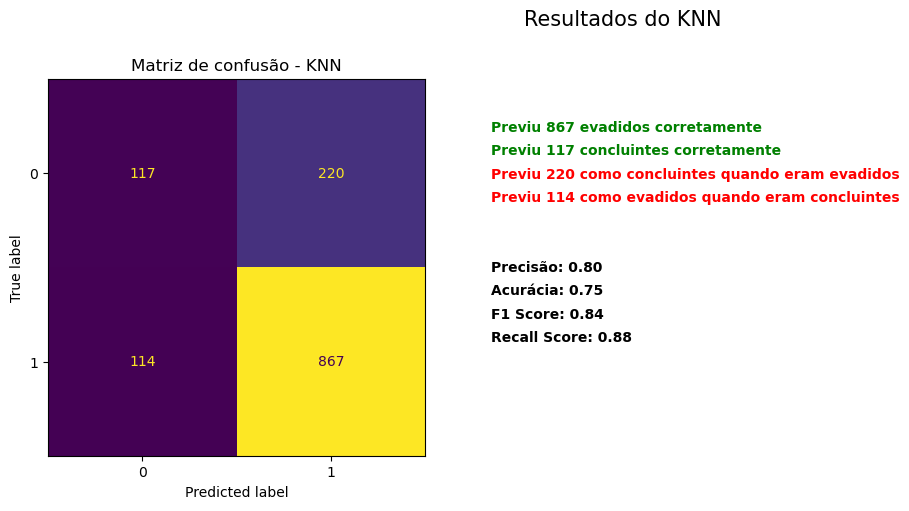

In [41]:
KNNpredicted = knn_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,KNNpredicted)
plot_conf_matrix_and_metrics(KNNpredicted,conf_matrix,knn_clf,'KNN')

Desempenho do Decision Tree

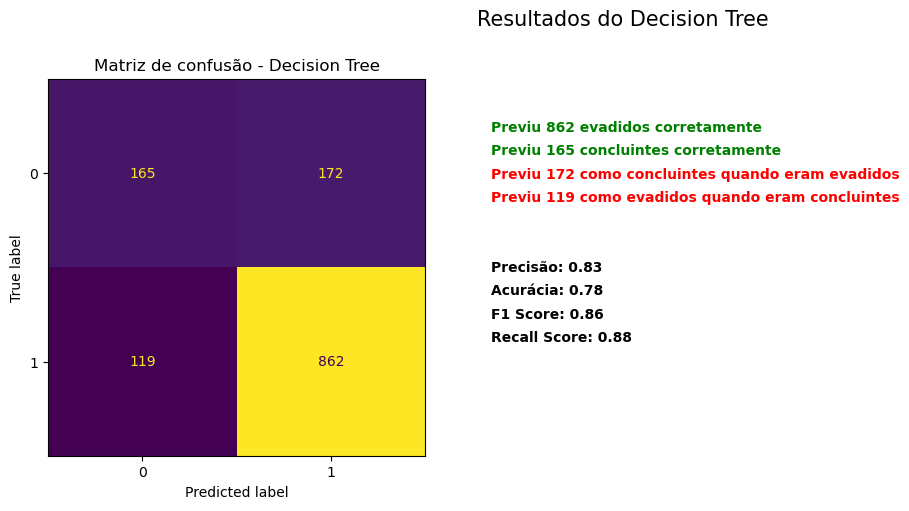

In [42]:
tree_predicted = tree_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,tree_predicted)
plot_conf_matrix_and_metrics(tree_predicted,conf_matrix,tree_clf,'Decision Tree')

Desempenho do SVM

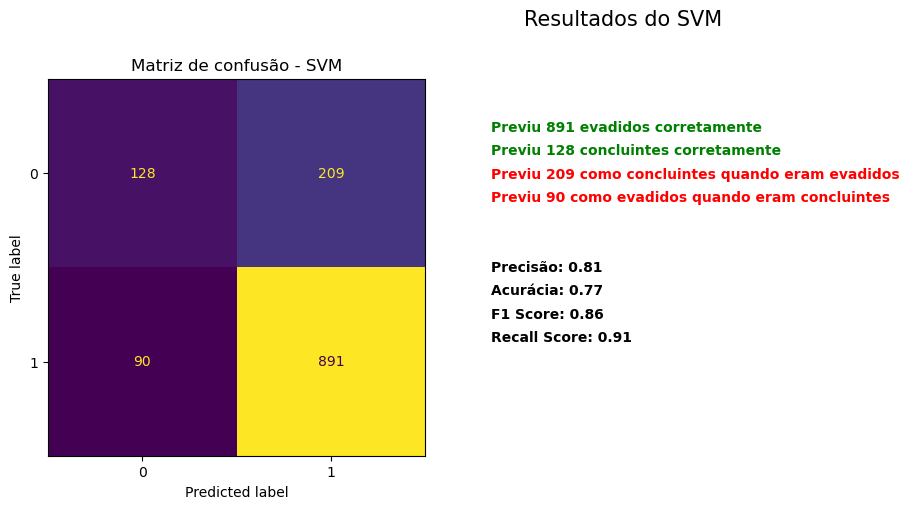

In [43]:
svm_predicted = svm_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,svm_predicted)
plot_conf_matrix_and_metrics(svm_predicted,conf_matrix,svm_clf,'SVM')

Desempenho do Logistic Regression

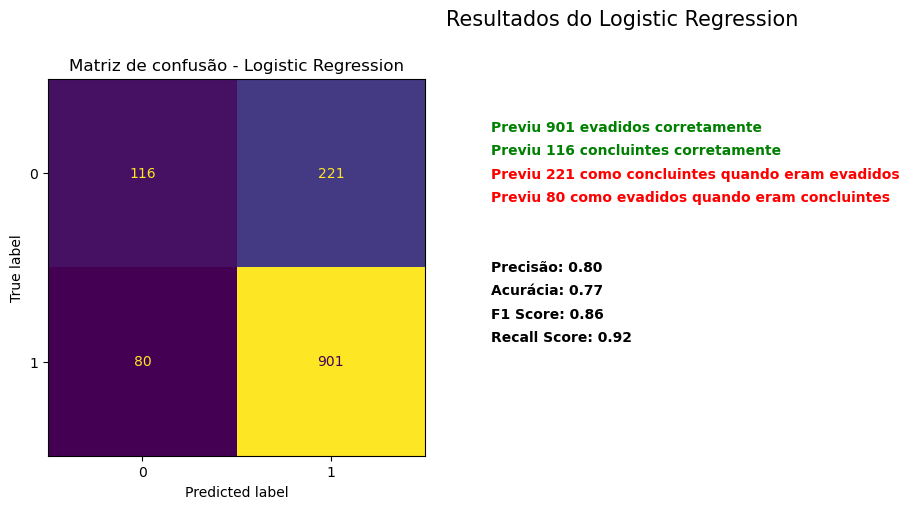

In [44]:
logreg_predicted = logreg_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,logreg_predicted)
plot_conf_matrix_and_metrics(logreg_predicted,conf_matrix,logreg_clf,'Logistic Regression')

## Visualizando a importância das features para o Decision Tree

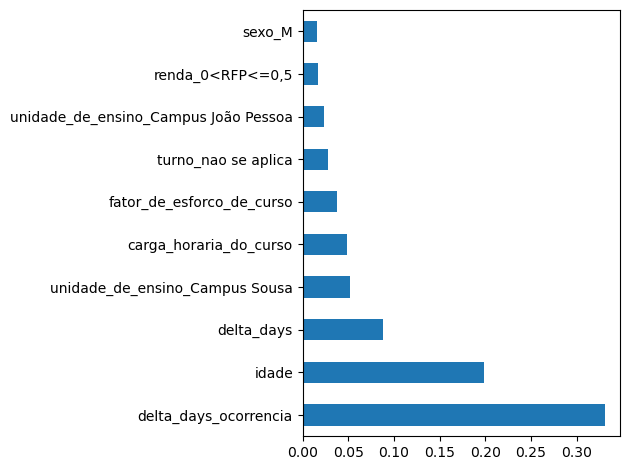

In [85]:
#plt.figure(figsize=(10,5))
feat_importances = pd.Series(tree_clf.feature_importances_, index=X_all.columns)
ax = feat_importances.nlargest(10).plot(kind='barh')
plt.tight_layout()

## Visualizando a importância das features para o Logistic Regression

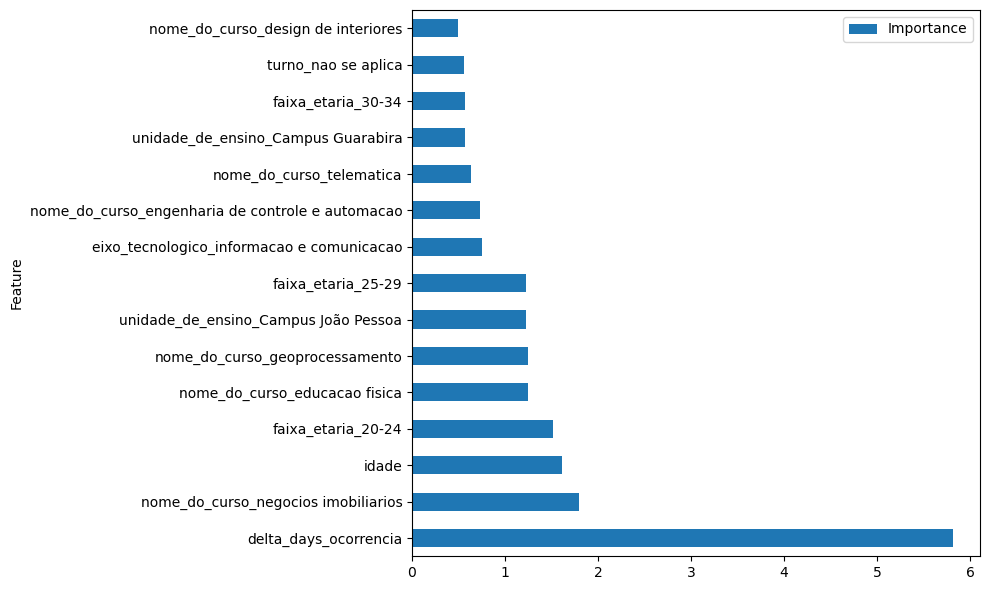

In [87]:
importance = logreg_clf.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_all.columns, 'Importance': np.abs(importance)})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)
ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.tight_layout()

## Comparando os modelos pela curva ROC

In [68]:
def compare_models_by_roc_curve(model,label_name):
 # fig, ax = plt.subplots()
  # calculando roc
  y_pred_probability = model.predict_proba(X_test)[::,1]
  # calculando também o auc
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probability)
  auc = metrics.roc_auc_score(y_test, y_pred_probability)
  plt.plot(fpr,tpr,label=label_name+",auc="+str(auc))
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel('True Positive Rate')

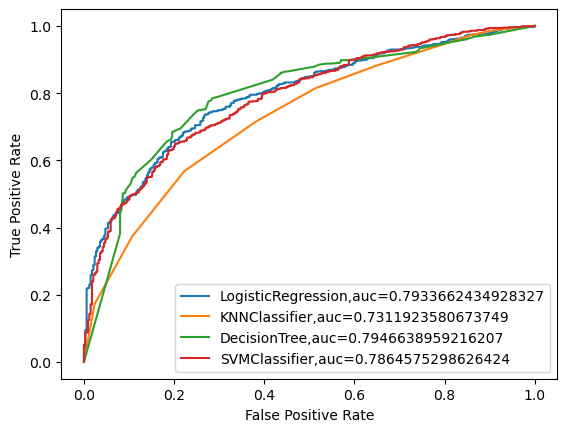

In [69]:
compare_models_by_roc_curve(logreg_clf,"LogisticRegression")
compare_models_by_roc_curve(knn_clf,"KNNClassifier")
compare_models_by_roc_curve(tree_clf,"DecisionTree")
compare_models_by_roc_curve(svm_clf,"SVMClassifier")

Logistic Regression e Decision Tree apresentaram AUCs muito próximos, mas velando em consideração também o recall desses dois modelos, o LogisticRegression apresentou recall de 0.92 contra 0.88 do Decision Tree, então este será o nosso modelo final: `Logistic Regression`.

## Salvando o modelo

In [80]:
import pickle

In [81]:
with open ('logreg_model.pkl','wb') as f:
  pickle.dump([enc, sc, le, logreg_clf], f)